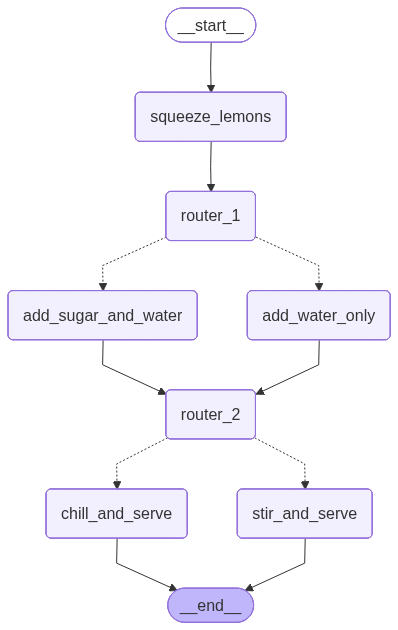

,lemons,sugar,water,juice,mix,final,prefer_cold
0,4,2,1 glass,Juice from 4 lemons,Juice from 4 lemons + 2 spoons sugar + 1 glass...,Juice from 4 lemons + 2 spoons sugar + 1 glass...,False
1,3,0,2 glasses,Juice from 3 lemons,Juice from 3 lemons + 2 glasses water,Juice from 3 lemons + 2 glasses water → Chille...,True


In [1]:
# Re-running the code after execution environment reset
from langgraph.graph import StateGraph
from typing import TypedDict, Dict, Any
from IPython.display import Image, display

# 1. Define state structure
class LemonState(TypedDict):
    lemons: int
    sugar: int
    water: str
    juice: str
    mix: str
    final: str
    prefer_cold: bool

# 2. Define processing nodes
def squeeze_lemons(state: Dict[str, Any]) -> Dict[str, Any]:
    state["juice"] = f"Juice from {state.get('lemons', 0)} lemons"
    return state

def add_sugar_and_water(state: Dict[str, Any]) -> Dict[str, Any]:
    state["mix"] = f"{state['juice']} + {state['sugar']} spoons sugar + {state['water']} water"
    return state

def add_water_only(state: Dict[str, Any]) -> Dict[str, Any]:
    state["mix"] = f"{state['juice']} + {state['water']} water"
    return state

def stir_and_serve(state: Dict[str, Any]) -> Dict[str, Any]:
    state["final"] = f"{state['mix']} → Stirred and ready to serve!"
    return state

def chill_and_serve(state: Dict[str, Any]) -> Dict[str, Any]:
    state["final"] = f"{state['mix']} → Chilled and served!"
    return state

# 3. Router nodes (just pass state through)
def router_1(state: Dict[str, Any]) -> Dict[str, Any]:
    return state

def router_2(state: Dict[str, Any]) -> Dict[str, Any]:
    return state

# 4. Decision functions
def check_sugar(state: Dict[str, Any]) -> str:
    return "add_sugar_and_water" if state.get("sugar", 0) > 0 else "add_water_only"

def route_serving(state: Dict[str, Any]) -> str:
    return "chill_and_serve" if state.get("prefer_cold", False) else "stir_and_serve"

# 5. Build graph
builder = StateGraph(LemonState)
builder.add_node("squeeze_lemons", squeeze_lemons)
builder.add_node("router_1", router_1)
builder.add_node("add_sugar_and_water", add_sugar_and_water)
builder.add_node("add_water_only", add_water_only)
builder.add_node("router_2", router_2)
builder.add_node("stir_and_serve", stir_and_serve)
builder.add_node("chill_and_serve", chill_and_serve)

builder.set_entry_point("squeeze_lemons")
builder.add_edge("squeeze_lemons", "router_1")

# First branching: sugar or not
builder.add_conditional_edges("router_1", check_sugar, {
    "add_sugar_and_water": "add_sugar_and_water",
    "add_water_only": "add_water_only"
})

# After either mix path, go to second router
builder.add_edge("add_sugar_and_water", "router_2")
builder.add_edge("add_water_only", "router_2")

# Second branching: serve cold or not
builder.add_conditional_edges("router_2", route_serving, {
    "stir_and_serve": "stir_and_serve",
    "chill_and_serve": "chill_and_serve"
})

# Define finish nodes
builder.set_finish_point("stir_and_serve")
builder.set_finish_point("chill_and_serve")

# Compile
graph = builder.compile()

# Visualize
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph visualization failed:", e)

# Test examples
scenarios = [
    {"lemons": 4, "sugar": 2, "water": "1 glass", "prefer_cold": False},
    {"lemons": 3, "sugar": 0, "water": "2 glasses", "prefer_cold": True},
]

results = []
for scenario in scenarios:
    state = {
        **scenario,
        "juice": "",
        "mix": "",
        "final": ""
    }
    result = graph.invoke(state)
    results.append(result)

import pandas as pd

df = pd.DataFrame(results)
df
